# Stack of NEON and other input data for AGB modelling  
Fine scale NEON data (everything except MERRA2) are warped to a common grid and extent  
Coarse data (MERRA2) are returned as a time-series table representing variables across time for a single lat/lon

SSURGO:  
https://planetarycomputer.microsoft.com/dataset/gnatsgo-rasters  
http://ncss-tech.github.io/AQP/soilDB/WCS-demonstration-01.html  
https://casoilresource.lawr.ucdavis.edu/soil-properties/download.php

In [1]:
import os
import sys
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import iolib, malib, geolib, filtlib, warplib

import glob
from glob import glob
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

from osgeo import gdal 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd
import pandas as pd
import numpy as np

import contextily as ctx
from shapely.geometry import box

In [2]:
def get_ndv(r_fn):
    with rasterio.open(r_fn) as src:
        return src.profile['nodata']

In [3]:
NEON_HYPERSPECTRAL_PRODUCT_DICTIONARY = {
    'SOURCE' : 'Airborne_Hyperspectral',
    'TYPE' : 'Spectrometer',
    'VegIndices': 'DP3.30026.001',
    'WaterIndices': 'DP3.30019.001',
    'FPAR': 'DP3.30014.001',
    'LAI': 'DP3.30012.001',
    'Albedo': 'DP3.30011.001',
    'Reflectance': 'DP3.30006.001',     
}
NEON_LIDAR_PRODUCT_DICTIONARY = {
    'SOURCE' : 'Airborne_Lidar',
    'TYPE' : 'DiscreteLidar',
    'ClassifiedPointCloud': 'DP1.30003.001',
    'AspectGtif': 'DP3.30025.001',
    'CHMGtif': 'DP3.30024.001',
    'DSMGtif': 'DP3.30024.001', 
    'DTMGtif': 'DP3.30024.001', 
    'FSDGtif': 'DP3.30024.001', #CHM & RUG from Glenn
}

## Site selection

In [4]:
SITE_SIZE_m = 1000 # length & width in meters of a site
SITE = 'MLBS'
YEAR = '2017'
REGION = '*' #'D07' # this not acutally needed
MAINDIR = '/explore/nobackup/projects/ilab/data/AGB'

## Coarse-scale data

In [5]:
dir_landsat = f'{MAINDIR}/LCMS'
dir_ssurgo  = f'{MAINDIR}/SSURGO/soilDB' #{SITE}/2020-07-01'
dir_merra2  = f'{MAINDIR}/MERRA2'

##### coarse data lists of grids

In [6]:
fn_landsat_list  = [os.path.join(dir_landsat, 'LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif'), os.path.join(dir_landsat, 'LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif')]
fn_ssurgo_list = [ x for x in glob(os.path.join(dir_ssurgo, f'*{SITE}*.tif')) if "tilejson" not in x and 'rendered' not in x ]
fn_ssurgo_list

['/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_wfifteenbar_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_dbthirdbar_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_awc_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_ph1to1h2o_r_0_25.tif']

## Fine-scale data:  

##### Test -- of a single pre-existing tile extent

In [7]:
if False:
    TILE_COORD = '540000_4136000'
    TILE_NAME = f'{YEAR}_NEON_{REGION}_{SITE}_DP3_{TILE_COORD}' 

    # Output extent dir
    OUT_EXTENT_DIR = os.path.join(MAINDIR, 'test','beta_pmm',TILE_COORD)
    !mkdir -p $OUT_DIR

##### Test -- fine data list of grids

In [8]:
if False:
    fn_lidar_fsd_list = glob(f'/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/{YEAR}/FullSite/{REGION}/{YEAR}_{SITE}_2/L3/DiscreteLidar/FSDGtif/{TILE_NAME}*.tif')
    fn_lidar_dtm_list = glob(f'/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/{YEAR}/FullSite/{REGION}/{YEAR}_{SITE}_2/L3/DiscreteLidar/DTMGtif/{TILE_NAME}*.tif')

    fn_lidar_list    = fn_lidar_fsd_list + fn_lidar_dtm_list
    fn_hyper_list    = glob(f'/explore/nobackup/projects/ilab/projects/AGB/test{SITE}/airHyper/{TILE_NAME}*.tif')

    # Copy into OUT_DIR the layers that wont end up getting warped
    for f in fn_lidar_list + fn_hyper_list:
        to_fn = os.path.join(OUT_DIR , os.path.basename(f))
        print(to_fn)
        !cp $f $to_fn

    fn_finescale_list = fn_lidar_list + fn_hyper_list

##### fine data list of grids (using VRTs)
Build the VRTs of tiled data from NEON (lidar and hyperspectral)  
some data are tiles across the larger study extent and need to be in a virtual mosaic to facilitate clipping anywhere within this extent

In [9]:
NEON_PROD_TILED_LIST = ['FSDGtif', 'DTMGtif', 'DSMGtif'] # Add hyperspectral here

In [10]:
fn_neon_vrt_list = []

for NEON_PROD in NEON_PROD_TILED_LIST:

    TIF_SEARCH_LIST = ['']
    
    # Special case
    if NEON_PROD == 'FSDGtif':
        TIF_SEARCH_LIST = ['CHM','RUG']
        
    for TIF_SEARCH in TIF_SEARCH_LIST:

        # Get the level of the data from the product
        PROD_LEVEL = NEON_LIDAR_PRODUCT_DICTIONARY[NEON_PROD].split('.')[0].split('DP')[1]
        
        SEARCH_STRING = f'{MAINDIR}/{NEON_LIDAR_PRODUCT_DICTIONARY["SOURCE"]}/{NEON_LIDAR_PRODUCT_DICTIONARY[NEON_PROD]}/neon-aop-products/{YEAR}/FullSite/{REGION}/{YEAR}_{SITE}_*/L{PROD_LEVEL}/{NEON_LIDAR_PRODUCT_DICTIONARY["TYPE"]}/{NEON_PROD}/*{TIF_SEARCH}.tif'
        print(f'Data search string: {SEARCH_STRING}') 
        fn_neon_prod_list = glob(SEARCH_STRING)
        #print(fn_neon_prod_list[0:10])
        
        # gdalbuilvrt here

        OUT_DIR = os.path.join(MAINDIR, 'test','beta_pmm')
        vrt_fn = os.path.join(OUT_DIR,f'{SITE}_{YEAR}_{NEON_PROD}_{TIF_SEARCH}.vrt')

        vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest', addAlpha=False)
        my_vrt = gdal.BuildVRT(vrt_fn , fn_neon_prod_list, options=vrt_options)
        my_vrt = None
        
        # Update the list used for warping
        fn_neon_vrt_list.append(vrt_fn)
        
fn_neon_vrt_list

fn_finescale_list = fn_neon_vrt_list

Data search string: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/*/2017_MLBS_*/L3/DiscreteLidar/FSDGtif/*CHM.tif
Data search string: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/*/2017_MLBS_*/L3/DiscreteLidar/FSDGtif/*RUG.tif
Data search string: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/*/2017_MLBS_*/L3/DiscreteLidar/DTMGtif/*.tif


Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DTMGtif/2017_NEON_D07_MLBS_DP3_545000_4139000_DTM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DTMGtif/2017_NEON_D07_MLBS_DP3_538000_4132000_DTM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DTMGtif/2017_NEON_D07_MLBS_DP3_545000_4136000_DTM.tif: TIFFReadDir

Data search string: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/*/2017_MLBS_*/L3/DiscreteLidar/DSMGtif/*.tif


Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DSMGtif/2017_NEON_D07_MLBS_DP3_545000_4134000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DSMGtif/2017_NEON_D07_MLBS_DP3_545000_4132000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DSMGtif/2017_NEON_D07_MLBS_DP3_545000_4135000_DSM.tif: TIFFReadDir

### From SITE, get SITE EXTENT for clipping during Warp

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 17 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


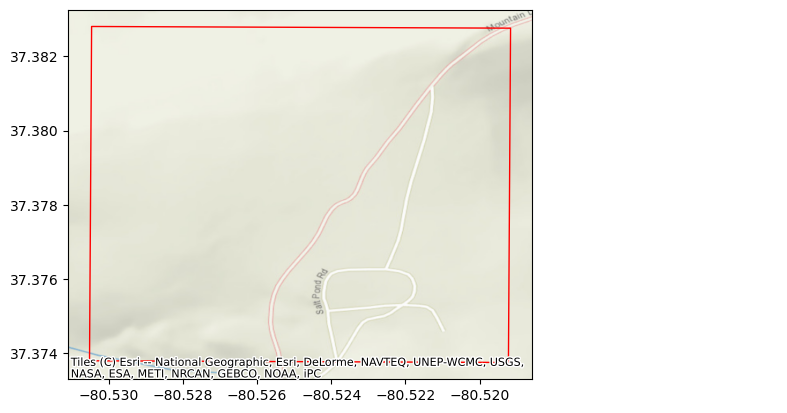

In [11]:
# Read NEON centroids
NEON_SITES_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/data/neon_sites_centroids.csv'
neon_sites_df = pd.read_csv(NEON_SITES_fn)

# Subset to site
site_df = neon_sites_df[neon_sites_df.site == SITE]


site_gdf = gpd.GeoDataFrame(site_df, geometry=gpd.points_from_xy(site_df.lon, site_df.lat))

# Get bbox of length & width SITE_SIZE around a centroid
site_gdf['left'], site_gdf['bottom'], site_gdf['right'], site_gdf['top'] = site_gdf['field_utm_x'] - (SITE_SIZE_m/2), site_gdf['field_utm_y'] - (SITE_SIZE_m/2), site_gdf['field_utm_x'] + (SITE_SIZE_m/2), site_gdf['field_utm_y'] + (SITE_SIZE_m/2) 
site_geometry = [box(x1, y1, x2, y2) for x1,y1,x2,y2 in zip(site_gdf.left, site_gdf.bottom, site_gdf.right, site_gdf.top)]

# Make site gdf in utm
site_gdf_utm = gpd.GeoDataFrame(site_gdf, geometry=site_geometry, crs=32600 + int(site_df['UTM zone']))

# Plot site extent
ax1 = site_gdf_utm.to_crs(4326).plot(facecolor='None', ec='r')

# Show map of site extent
ax1 = ctx.add_basemap(ax1, crs=4326, 
        #source = ctx.providers.Gaode.Satellite
        #source = ctx.providers.Esri.WorldShadedRelief
        #source = ctx.providers.Esri.WorldGrayCanvas
        source = ctx.providers.Esri.NatGeoWorldMap
        #source = ctx.providers.Esri.WorldImagery
        #source = ctx.providers.Esri.DeLorme
    )

#from shapely.geometry import shape
#shape(site_gdf_utm['geometry']).bounds

# Get extent as tuple used for warp
SITE_EXTENT = rasterio.features.bounds(site_gdf_utm['geometry'])

# Convert to list of strings for output dir name
SITE_EXTENT_LIST = [str(x) for x in SITE_EXTENT]

## Set output SITE EXTENT dir

In [12]:
# Output extent dir
DIR_SITE_EXTENT = '_'.join([SITE, YEAR] + SITE_EXTENT_LIST)
OUT_EXTENT_DIR = os.path.join(MAINDIR, 'test','beta_pmm', DIR_SITE_EXTENT)
!mkdir -p $OUT_EXTENT_DIR

### Combine the lists (substacks)

In [13]:
#fn_list = fn_lidar_list + fn_hyper_list + fn_landsat_list + fn_ssurgo_list
fn_list = fn_finescale_list + fn_landsat_list + fn_ssurgo_list
print(len(fn_list))
fn_list

10


['/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_FSDGtif_CHM.vrt',
 '/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_FSDGtif_RUG.vrt',
 '/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_DTMGtif_.vrt',
 '/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_DSMGtif_.vrt',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_wfifteenbar_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_dbthirdbar_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_awc_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_ph1to1h2o_r_0_25.tif']

In [14]:
# Check nodata values of input data
ndv_list = [get_ndv(fn) for fn in fn_list]
print(ndv_list)

[-9999.0, -9999.0, -9999.0, -9999.0, 0.0, 0.0, nan, nan, nan, nan]


## Warp the grids

In [15]:
# ---Doing the warp ---
# Warp with a write out 
warp_ds_list = warplib.diskwarp_multi_fn(fn_list, res=1, extent=SITE_EXTENT, t_srs=fn_finescale_list[0], r='mode', dst_ndv=-10001, outdir=OUT_EXTENT_DIR)


Warping all inputs to the following:
Resolution: 1.0
Extent: [541567.6, 4136443.0, 542567.6, 4137443.0]
Projection: '+proj=utm +zone=17 +datum=WGS84 +units=m +no_defs'
Resampling alg: mode

1 of 10: /explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_FSDGtif_CHM.vrt
nl: 1000 ns: 1000 res: 1.000
0...10...20...30...40...50...60...70...80...90...2 of 10: /explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_FSDGtif_RUG.vrt
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 10: /explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_DTMGtif_.vrt
nl: 1000 ns: 1000 res: 1.000


Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DTMGtif/2017_NEON_D07_MLBS_DP3_542000_4137000_DTM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DTMGtif/2017_NEON_D07_MLBS_DP3_542000_4136000_DTM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DTMGtif/2017_NEON_D07_MLBS_DP3_541000_4136000_DTM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_ML

100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 10: /explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_DSMGtif_.vrt
nl: 1000 ns: 1000 res: 1.000


Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DSMGtif/2017_NEON_D07_MLBS_DP3_542000_4136000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DSMGtif/2017_NEON_D07_MLBS_DP3_542000_4137000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar/DSMGtif/2017_NEON_D07_MLBS_DP3_541000_4137000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2017/FullSite/D07/2017_ML

100 - done.
0...10...20...30...40...50...60...70...80...90...5 of 10: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...6 of 10: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...7 of 10: /explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_wfifteenbar_r_0_25.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...8 of 10: /explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_dbthirdbar_r_0_25.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...9 of 10: /explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_awc_r_0_25.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...4

### Note: NoDATA values only changed if the file end up being warped

In [16]:
print([iolib.get_ndv_ds(ds) for ds in warp_ds_list])

[-10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0]


## Coarse-scale data  
### Combine MERRA2 into a single time series file  
this table is a daily time-series of 10 vars from 2016-2021 for a single MERRA2 grid cell at `(-80.5248, 37.37831 )`   
'mean_temperature..K.''max_temperature..K.''min_temperature..K.''vpd..kPa.''high_temperature_day''freezing_day''growing_degree..K.''solar_radiation..W.m2.''soil_moisture..m3.m3.''precipitation..mm.day.'

In [17]:
dir_merra2

'/explore/nobackup/projects/ilab/data/AGB/MERRA2'

In [18]:
if True:
    merra2_df = pd.concat(pd.read_csv(fn) for fn in glob(f'{dir_merra2}/*.csv'))
    #lon, lat =  (-80.5248, 37.37831 )

    merra2_df.head()
    merra2_df.to_csv(os.path.join(OUT_EXTENT_DIR, f'merra2_{SITE}_daily_2016_2021.csv'))

In [19]:
OUT_EXTENT_DIR

'/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2017_541567.6_4136443.0_542567.6_4137443.0'